# Configurações Iniciais

In [857]:
import sys
import os

# Pega o diretório de trabalho atual (que é /notebooks)
notebook_dir = os.getcwd()
# Sobe um nível para o diretório raiz do projeto
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))

# Adiciona a raiz do projeto ao sys.path se ainda não estiver lá
if project_root not in sys.path:
    print(f"Adicionando a raiz do projeto ao path: {project_root}")
    sys.path.append(project_root)

In [858]:
from src.load_df import load_df
from src.convert_to_datetime import convert_to_datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mticker

from pathlib import Path
import joblib

from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc

import lightgbm as lgb
from src.experiment import run_experiment

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 

from src.RankCountVectorizer import RankCountVectorizer

In [859]:
# Carregar os DataFrames
df_targets = load_df("../data/targets.parquet")

df_cadastral = load_df("../data/base_cadastral.parquet")
df_emprestimos = load_df("../data/historico_emprestimos.parquet")
df_submissao = load_df("../data/base_submissao.parquet")
df_parcelas = load_df("../data/historico_parcelas_consolidado.parquet")
dicionario = load_df("../data/dicionario_dados.csv")

In [860]:
blue = '#006e9cff'
red = "#cd6454ff"
gray = '#647f8f'
cyan = '#18dbdbff'

## Criação de Target

In [861]:
def create_target(df_parcelas: pd.DataFrame, dias_atraso: int, mob: int, type: str = 'over'):
    """
    Cria uma variável target binária (0 ou 1) para cada contrato.

    A target será 1 se o cliente alguma vez (EVER) atrasou 'dias_atraso' ou mais
    em qualquer parcela dentro dos primeiros 'mob' meses (Month on Book) do contrato.

    Args:
        df_parcelas (pd.DataFrame): DataFrame com os dados das parcelas.
                                    Deve conter 'id_contrato', 'numero_parcela',
                                    'data_prevista_pagamento' e 'data_real_pagamento'.
        dias_atraso (int): O número de dias de atraso para considerar inadimplência (X).
        mob (int): A janela de observação em meses (Y).

    Returns:
        pd.DataFrame: Um DataFrame com 'id_contrato' e a coluna da nova target.
    """

    df = df_parcelas.copy()

    # calcula a diferença em dias
    df['dias_atraso'] = (df['data_real_pagamento'] - df['data_prevista_pagamento']).dt.days

    # O 'numero_parcela' é um proxy para o MOB
    if type == 'over':
        df_mob = df[df['numero_parcela'] == mob].copy()
    else:
        df_mob = df[df['numero_parcela'] <= mob].copy()

    # verificar se a condição de inadimplência foi atingida
    df_mob['inadimplente'] = (df_mob['dias_atraso'] >= dias_atraso).astype(int)

    # se o valor máximo de 'inadimplente' para um contrato for 1, ele atingiu a condição.
    target = df_mob.groupby('id_contrato')['inadimplente'].max().reset_index()
    return target

In [862]:
df_targets = create_target(df_parcelas, dias_atraso=15, mob=6, type='ever')

# Criação da ABT

In [863]:
# listar as colunas que precisam de conversão em cada DataFrame
colunas_data_emprestimos = [
    'data_decisao',
    'data_liberacao',
    'data_primeiro_vencimento',
    'data_ultimo_vencimento_original',
    'data_ultimo_vencimento',
    'data_encerramento'
]

colunas_data_parcelas = [
    'data_prevista_pagamento',
    'data_real_pagamento'
]

colunas_data_cadastral = [
    'data_nascimento'
]

df_parcelas = convert_to_datetime(df_parcelas, colunas_data_parcelas)
df_emprestimos = convert_to_datetime(df_emprestimos, colunas_data_emprestimos)
df_cadastral = convert_to_datetime(df_cadastral, colunas_data_cadastral)


--- Verificando tipos de dados ANTES da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_prevista_pagamento    datetime64[ns]
data_real_pagamento        datetime64[ns]
dtype: object

--- Verificando tipos de dados ANTES da conversão ---
data_decisao                       object
data_liberacao                     object
data_primeiro_vencimento           object
data_ultimo_vencimento_original    object
data_ultimo_vencimento             object
data_encerramento                  object
dtype: object

--- Verificando tipos de dados DEPOIS da conversão ---
data_decisao                       datetime64[ns]
data_liberacao                     datetime64[ns]
data_primeiro_vencimento           datetime64[ns]
data_ultimo_vencimento_original    datetime64[ns]
data_ultimo_vencimento             datetime64[ns]
data_encerramento                  datetime64[ns]
dtype: object

-

In [864]:
data_atual_idade = pd.to_datetime('today')
df_cadastral['idade_cliente'] = ((data_atual_idade - df_cadastral['data_nascimento']).dt.days / 365.25).astype(int)

df_cadastral = df_cadastral.drop(columns=['data_nascimento', 'sexo'])
df_cadastral['renda_por_familiar'] = df_cadastral['renda_anual'] / df_cadastral['qtd_membros_familia']

In [865]:
include_emprestimo_columns = [
                  'id_contrato',
                  'id_cliente',
                  'dia_semana_solicitacao',
                  'hora_solicitacao',
                  'tipo_contrato',
                  'valor_credito',
                  'valor_bem',
                  'valor_parcela',
                  'data_decisao'
                  ]

df = df_emprestimos.copy()
df = df[include_emprestimo_columns]

In [866]:
df_merged = df.merge(df_cadastral, on='id_cliente', how='left')
df_merged = df_merged.merge(df_targets, on='id_contrato', how='right')

In [867]:
df_merged['inadimplente'].isna().sum()

np.int64(0)

In [868]:
df_merged['data_decisao'].max()

Timestamp('2025-02-14 00:00:00')

In [869]:
df_merged['inadimplente'].value_counts(normalize=True)

inadimplente
0    0.964941
1    0.035059
Name: proportion, dtype: float64

In [870]:

class FeatureEngineeringPipeline:
    """
    Encapsula o pipeline de feature engineering para a criação da ABT de score de crédito.
    
    A classe armazena as configurações (janelas, colunas, agregações) e
    orquestra a execução das transformações.
    
    Esta versão implementa a API fit/transform para lidar com encoders supervisionados
    como o CatBoostEncoder.
    """
    def __init__(self, 
                 time_windows_months=[3, 6], 
                 historical_num_cols=['valor_credito', 'valor_bem', 'valor_parcela'],
                 historical_aggs=['mean', 'std', 'min', 'max', 'sum'],
                 categorical_cols=[],
                 date_col='data_decisao'):
        
        self.time_windows_months = time_windows_months
        self.time_windows_days = [w * 30 for w in time_windows_months]
        self.historical_num_cols = historical_num_cols
        self.historical_aggs = historical_aggs

        self.categorical_cols = categorical_cols

        self.date_col = date_col

        self.encoder = RankCountVectorizer()
            
        print(f"Pipeline initialized with windows: {time_windows_months}m")
        print("CAT COLS:", self.categorical_cols)

    def fit(self, df, df_cadastral, df_emprestimos, df_parcelas, target_col):
        """
        Orquestra a execução completa do pipeline e "fitta" os encoders.
        
        Args:
            df (pd.DataFrame): DataFrame principal (novas solicitações de treino).
            ... (outros DataFrames) ...
            y (pd.Series): A variável-alvo (target) para o encoder supervisionado.
            
        Returns:
            pd.DataFrame: A ABT (Analytical Base Table) finalizada e fittada.
        """
        print("--- Pipeline FIT started ---")
        
        # Etapa 1: Merge de dados cadastrais
        df_processed = self._merge_cadastral(df, df_cadastral)
        
        # Etapa 2: Criação de features especiais (atrasos, empréstimos aceitos)
        df_processed = self._create_special_features(df_processed, df_emprestimos, df_parcelas)
        
        # Etapa 3: Criação de features históricas (auto-agregação)
        df_processed = self._create_historical_features(df_processed)
        
        # Etapa 4: Criação de features de data
        df_processed = self._create_date_features(df_processed)
        
        # Etapa 5: Fit do encoder categórico
        df_processed = self._fit_encoder(df_processed, target_col)
        
        print(f"--- Pipeline FIT finished. ABT shape: {df_processed.shape} ---")
        return df_processed

    def transform(self, df, df_cadastral, df_emprestimos, df_parcelas):
        """
        Orquestra a execução completa do pipeline em novos dados (inferência/validação).
        Aplica os encoders "fittados" anteriormente.
        """
        print("--- Pipeline TRANSFORM started ---")
        
        if self.encoder is None and self.categorical_cols:
            raise RuntimeError("Pipeline must be 'fit' before 'transform' if using categorical encoders.")

        # Etapa 1: Merge de dados cadastrais
        df_processed = self._merge_cadastral(df, df_cadastral)
        
        # Etapa 2: Criação de features especiais (atrasos, empréstimos aceitos)
        df_processed = self._create_special_features(df_processed, df_emprestimos, df_parcelas)
        
        # Etapa 3: Criação de features históricas (auto-agregação)
        df_processed = self._create_historical_features(df_processed)
        
        # Etapa 4: Criação de features de data
        df_processed = self._create_date_features(df_processed)
        
        # Etapa 5: Transform do encoder categórico
        df_processed = self._transform_encoder(df_processed)
        
        print(f"--- Pipeline TRANSFORM finished. ABT shape: {df_processed.shape} ---")
        return df_processed

    def _merge_cadastral(self, df, df_cadastral):
        """Etapa 1: Merge com dados cadastrais."""
        print("[Step 1/5] Merging cadastral data...")
        return df.merge(df_cadastral, on='id_cliente', how='left')

    def _create_special_features(self, df, df_emprestimos, df_parcelas):
        """Etapa 2: Cria features de janelas temporais de fontes externas."""
        print("[Step 2/5] Creating special features (loans and delays)...")
        # ... (código existente, apenas ajustando prints) ...
        
        # Usa o índice para garantir junção correta, mesmo com datas duplicadas
        df_featured = df.reset_index().rename(columns={'index': 'id_original_emprestimo'})
        df_featured[self.date_col] = pd.to_datetime(df_featured[self.date_col])

        # --- 1. Cálculo de Empréstimos Aceitos (Vetorizado) ---
        print("  -> Calculating accepted loans...")
        # ... (código existente inalterado) ...
        hist_emprestimos = df_emprestimos[df_emprestimos['status_contrato'].isin(['Approved', 'Aprovado'])][['id_cliente', 'data_decisao']].copy()
        hist_emprestimos.rename(columns={'data_decisao': 'data_decisao_hist'}, inplace=True)
        hist_emprestimos['data_decisao_hist'] = pd.to_datetime(hist_emprestimos['data_decisao_hist'])

        merged_emprestimos = pd.merge(
            df_featured[['id_original_emprestimo', 'id_cliente', self.date_col]], 
            hist_emprestimos, 
            on='id_cliente'
        )
        merged_emprestimos = merged_emprestimos[merged_emprestimos['data_decisao_hist'] < merged_emprestimos[self.date_col]]
        merged_emprestimos['time_diff'] = (merged_emprestimos[self.date_col] - merged_emprestimos['data_decisao_hist']).dt.days

        for window_days in self.time_windows_days:
            window_months = int(window_days / 30)
            col_name = f'num_emp_aceitos_{window_months}m'
            counts = merged_emprestimos[merged_emprestimos['time_diff'] <= window_days].groupby('id_original_emprestimo').size()
            df_featured[col_name] = df_featured['id_original_emprestimo'].map(counts).fillna(0).astype(int)

        # --- 2. Cálculo de Atraso Médio (Vetorizado) ---
        print("  -> Calculating average delay...")
        # ... (código existente inalterado) ...
        hist_parcelas = df_parcelas[['id_contrato', 'data_prevista_pagamento', 'data_real_pagamento']].copy()
        hist_parcelas['data_prevista_pagamento'] = pd.to_datetime(hist_parcelas['data_prevista_pagamento'])
        hist_parcelas['data_real_pagamento'] = pd.to_datetime(hist_parcelas['data_real_pagamento'])
        hist_parcelas['atraso'] = (hist_parcelas['data_real_pagamento'] - hist_parcelas['data_prevista_pagamento']).dt.days.clip(lower=0)
        hist_parcelas = pd.merge(hist_parcelas, df_emprestimos[['id_contrato', 'id_cliente']], on='id_contrato', how='left')
        hist_parcelas.rename(columns={'data_prevista_pagamento': 'data_prevista_hist'}, inplace=True)
        hist_parcelas = hist_parcelas.dropna(subset=['id_cliente']) # Garante que temos cliente

        merged_parcelas = pd.merge(
            df_featured[['id_original_emprestimo', 'id_cliente', self.date_col]], 
            hist_parcelas, 
            on='id_cliente'
        )
        merged_parcelas = merged_parcelas[merged_parcelas['data_prevista_hist'] < merged_parcelas[self.date_col]]
        merged_parcelas['time_diff'] = (merged_parcelas[self.date_col] - merged_parcelas['data_prevista_hist']).dt.days
        
        for window_days in self.time_windows_days:
            window_months = int(window_days / 30)
            col_name = f'atraso_medio_{window_months}m'
            
            merged_parcelas['atraso_na_janela'] = np.where(merged_parcelas['time_diff'] <= window_days, merged_parcelas['atraso'], np.nan)
            avg_delay = merged_parcelas.groupby('id_original_emprestimo')['atraso_na_janela'].mean()
            df_featured[col_name] = df_featured['id_original_emprestimo'].map(avg_delay).fillna(0)

        return df_featured.set_index('id_original_emprestimo')

    def _create_historical_features(self, df):
        """Etapa 3: Cria features de agregação do histórico do próprio cliente (self-join)."""
        print("[Step 3/5] Creating historical features (self-aggregation)...")
        # ... (código existente inalterado) ...
        
        # 1. Preparar o DataFrame base
        base_df = df[['id_cliente', self.date_col] + self.historical_num_cols].copy()
        base_df[self.date_col] = pd.to_datetime(base_df[self.date_col])
        # Usar o índice original como um identificador único
        base_df = base_df.reset_index().rename(columns={'index': 'id_original_emprestimo'})

        # 2. O Self-Join
        df_merged = pd.merge(
            base_df,
            base_df,
            on='id_cliente',
            suffixes=('_atual', '_hist')
        )

        # 3. Filtro Temporal: Histórico ANTERIOR ao atual
        df_merged = df_merged[df_merged[f'{self.date_col}_hist'] < df_merged[f'{self.date_col}_atual']].copy()

        # 4. Calcular a diferença em dias
        df_merged['time_diff_days'] = (df_merged[f'{self.date_col}_atual'] - df_merged[f'{self.date_col}_hist']).dt.days

        df_final = df.copy()

        # 5. Loop para cada janela de tempo
        for w in self.time_windows_months:
            window_days = int(w * 30)
            print(f"  -> Calculating for {w}-month window ({window_days} days)...")
            
            df_window = df_merged[df_merged['time_diff_days'] <= window_days]

            hist_cols = [f'{col}_hist' for col in self.historical_num_cols]
            
            agg_result = df_window.groupby('id_original_emprestimo_atual')[hist_cols].agg(self.historical_aggs)
            
            # Achata os nomes das colunas do MultiIndex
            agg_result.columns = [f"hist_{col.replace('_hist', '')}_{w}m_{agg}" for col, agg in agg_result.columns]
            
            # Junta os resultados de volta ao DataFrame final (usando o índice)
            df_final = df_final.join(agg_result)

        # Preenche NaNs (primeiro empréstimo de um cliente não tem histórico)
        hist_feature_cols = [c for c in df_final.columns if isinstance(c, str) and c.startswith('hist_')]
        df_final[hist_feature_cols] = df_final[hist_feature_cols].fillna(0)
        
        print(f"  -> Created {len(hist_feature_cols)} historical features.")
        
        return df_final

    def _create_date_features(self, df):
        """Etapa 4: Cria features de data (conforme solicitado)."""
        print("[Step 4/5] Creating date features...")
        if self.date_col in df.columns:
            # Garantir que a coluna é datetime antes de extrair componentes
            df[self.date_col] = pd.to_datetime(df[self.date_col], errors='coerce')
            
            df[f'{self.date_col}_mes'] = df[self.date_col].dt.month
            df[f'{self.date_col}_dia_do_mes'] = df[self.date_col].dt.day
            
        return df

    def _fit_encoder(self, df, target_col):
        """Etapa 5: Fit do encoder categórico."""

        if len(self.categorical_cols) == 0:
            self.categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
            
        print("[Step 5/5] Fitting encoder...")
        
        # Assegura que colunas categóricas são string/object para o encoder
        # for col in self.categorical_cols:
        #     if col in df.columns:
        #         df[col] = df[col].astype(str).fillna('NA')
        
        df = self.encoder.fit_transform(df, self.categorical_cols)

        return df

    def _transform_encoder(self, df):
        """Etapa 5: Transform com encoder categórico."""
        if not self.categorical_cols:
            print("[Step 5/5] No categorical encoding configured.")
            return df
        
        if self.encoder is None:
             raise RuntimeError("Encoder has not been fitted. Call 'fit' first.")
            
        print("[Step 5/5] Transforming with encoder...")
        
        # Assegura que colunas categóricas são string/object para o encoder
        # for col in self.categorical_cols:
        #     if col in df.columns:
        #         df[col] = df[col].astype(str).fillna('NA')
                
        df = self.encoder.transform(df, self.categorical_cols)
        return df

In [871]:
# --- CONFIGURAÇÃO ---
target_col = 'inadimplente'  # <--- CORRIGIDO
date_col = 'data_decisao'

# 1. PREPARAÇÃO DOS DADOS E DIVISÃO
# Garante que é datetime
df_merged[date_col] = pd.to_datetime(df_merged[date_col])
df_merged.sort_values(date_col, inplace=True)

# Filtro de datas macro (conforme seu snippet)
df_train_test = df_merged.copy()
df_train_test = df_train_test[df_train_test[date_col] < '2024-01-01']
df_train_test = df_train_test[df_train_test[date_col] >= '2020-01-01']

# Definição dos índices de corte (70% / 15% / 15%)
train_end_idx = int(len(df_train_test) * 0.70)
validation_end_idx = int(len(df_train_test) * 0.85)

# Split dos DataFrames
df_train = df_train_test.iloc[:train_end_idx]
df_val = df_train_test.iloc[train_end_idx:validation_end_idx]
df_test = df_train_test.iloc[validation_end_idx:]

In [872]:
featureEngeering = FeatureEngineeringPipeline()

df_train_abt = featureEngeering.fit(df_train, df_cadastral, df_emprestimos, df_parcelas, target_col= 'inadimplente')
df_val_abt = featureEngeering.transform(df_val, df_cadastral, df_emprestimos, df_parcelas)
df_test_abt = featureEngeering.transform(df_test, df_cadastral, df_emprestimos, df_parcelas)

df_train_abt['safra'] = df_train_abt['data_decisao'].dt.strftime('%Y-%m')
df_val_abt['safra'] = df_val_abt['data_decisao'].dt.strftime('%Y-%m')
df_test_abt['safra'] = df_test_abt['data_decisao'].dt.strftime('%Y-%m')

df_train_abt.drop(columns=['data_decisao'], inplace=True)
df_val_abt.drop(columns=['data_decisao'], inplace=True)
df_test_abt.drop(columns=['data_decisao'], inplace=True)

Pipeline initialized with windows: [3, 6]m
CAT COLS: []
--- Pipeline FIT started ---
[Step 1/5] Merging cadastral data...
[Step 2/5] Creating special features (loans and delays)...
  -> Calculating accepted loans...
  -> Calculating average delay...
[Step 3/5] Creating historical features (self-aggregation)...
  -> Calculating for 3-month window (90 days)...
  -> Calculating for 6-month window (180 days)...
  -> Created 30 historical features.
[Step 4/5] Creating date features...
[Step 5/5] Fitting encoder...
--- Pipeline FIT finished. ABT shape: (44310, 76) ---
--- Pipeline TRANSFORM started ---
[Step 1/5] Merging cadastral data...
[Step 2/5] Creating special features (loans and delays)...
  -> Calculating accepted loans...
  -> Calculating average delay...
[Step 3/5] Creating historical features (self-aggregation)...
  -> Calculating for 3-month window (90 days)...
  -> Calculating for 6-month window (180 days)...
  -> Created 30 historical features.
[Step 4/5] Creating date features

In [873]:
X_train = df_train_abt.drop(columns=['id_contrato', 'id_cliente', 'inadimplente', 'safra'])
y_train = df_train_abt['inadimplente']

X_val = df_val_abt.drop(columns=['id_contrato', 'id_cliente', 'inadimplente', 'safra'])
y_val = df_val_abt['inadimplente']

X_test = df_test_abt.drop(columns=['id_contrato', 'id_cliente', 'inadimplente', 'safra'])
y_test = df_test_abt['inadimplente']

Limites Temporais Detectados:
Fim Treino: 2023-04-08 00:00:00
Fim Validação: 2023-08-25 00:00:00


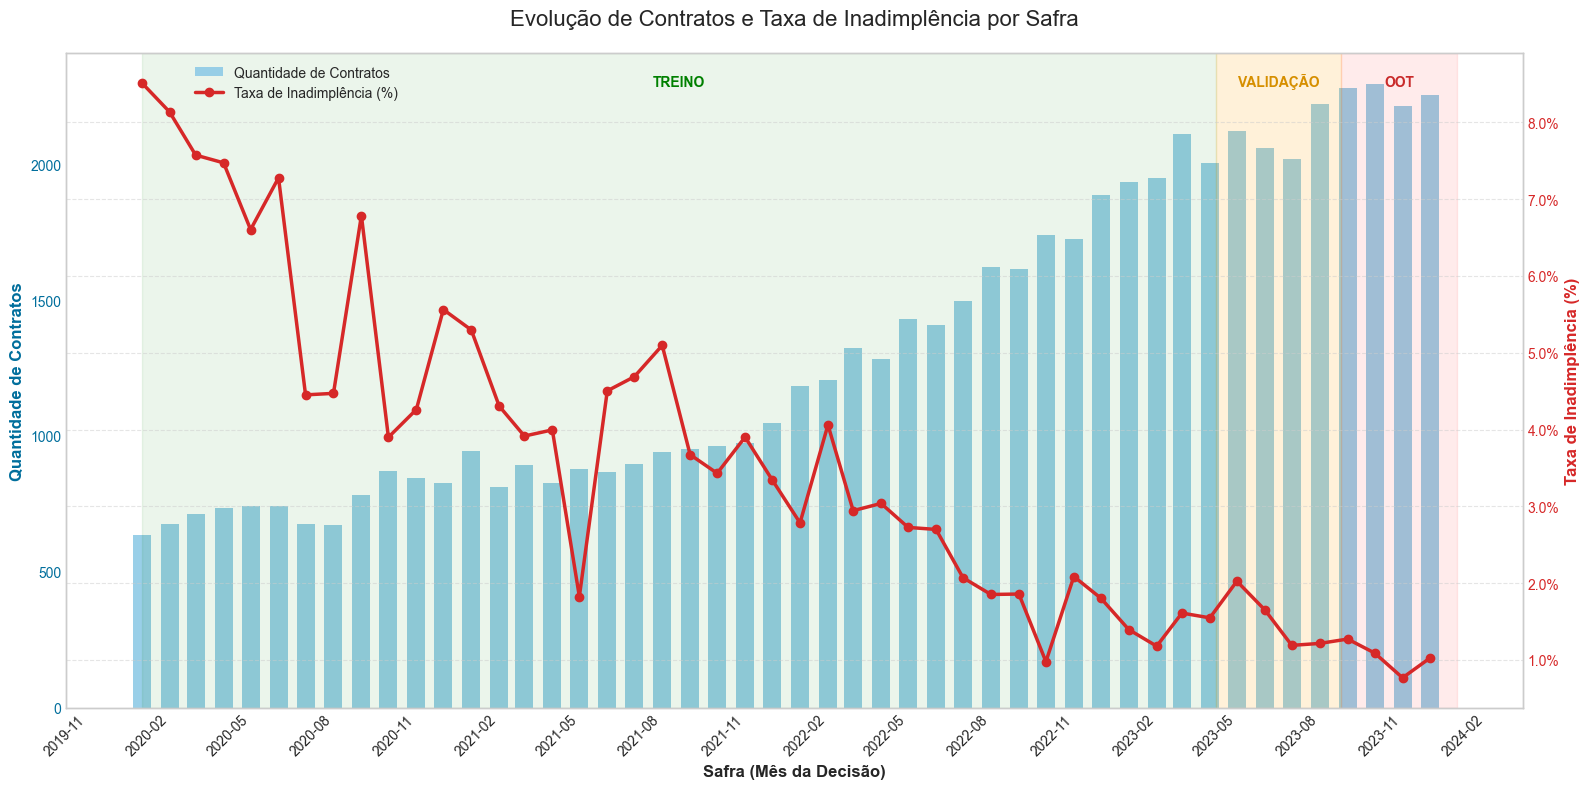

In [874]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

# --- CAPTURA DAS DATAS LIMITE PARA O GRÁFICO ---
# Captura a data exata onde cada bloco termina para desenhar o fundo
start_date = df_train[date_col].min()
split_train_val = df_train[date_col].max()
split_val_test = df_val[date_col].max()
end_date = df_test[date_col].max()

print(f"Limites Temporais Detectados:")
print(f"Fim Treino: {split_train_val}")
print(f"Fim Validação: {split_val_test}")

# 2. AGREGAÇÃO MENSAL PARA PLOTAGEM
# Criamos uma coluna auxiliar 'safra_mes' apenas para agrupar o gráfico
df_plot = df_train_test.copy()
df_plot['safra_mes'] = df_plot[date_col].dt.to_period('M').dt.to_timestamp()

# Agrupa: Contagem (Volume) e Média do Target (Taxa de Inadimplência)
df_agg = df_plot.groupby('safra_mes').agg(
    volumetria=('safra_mes', 'count'),
    taxa_inad=(target_col, 'mean') # Usa 'inadimplente'
).reset_index()

# 3. PLOTAGEM DO GRÁFICO
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax1 = plt.subplots(figsize=(16, 8))

# --- Eixo 1: Barras (Volume de Contratos) ---
bars = ax1.bar(
    df_agg['safra_mes'], 
    df_agg['volumetria'], 
    width=20, # Ajuste a largura visual das barras
    color='#8ecae6', # Azul claro
    label='Quantidade de Contratos',
    alpha=0.9
)

ax1.set_xlabel('Safra (Mês da Decisão)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Quantidade de Contratos', fontsize=12, color= blue, fontweight='bold')
ax1.tick_params(axis='y', labelcolor= blue)
ax1.grid(False) 

# --- Eixo 2: Linha (Taxa de Inadimplência) ---
ax2 = ax1.twinx() 
line = ax2.plot(
    df_agg['safra_mes'], 
    df_agg['taxa_inad'], 
    color='#d62828', # Vermelho forte
    marker='o',
    linewidth=2.5,
    markersize=6,
    label='Taxa de Inadimplência (%)'
)
ax2.set_ylabel('Taxa de Inadimplência (%)', fontsize=12, color='#d62828', fontweight='bold')
ax2.tick_params(axis='y', labelcolor='#d62828')
ax2.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0)) 
ax2.grid(axis='y', linestyle='--', alpha=0.5)

# --- Áreas de Fundo (Treino, Validação, OOT) ---
# Treino (Verde)
ax1.axvspan(start_date, split_train_val, color='green', alpha=0.08)
ax1.text(start_date + (split_train_val - start_date)/2, ax1.get_ylim()[1]*0.95, 
         'TREINO', ha='center', color='green', fontweight='bold', fontsize=10)

# Validação (Amarelo/Laranja)
ax1.axvspan(split_train_val, split_val_test, color='orange', alpha=0.15)
ax1.text(split_train_val + (split_val_test - split_train_val)/2, ax1.get_ylim()[1]*0.95, 
         'VALIDAÇÃO', ha='center', color='#d68f00', fontweight='bold', fontsize=10)

# Teste / OOT (Vermelho)
ax1.axvspan(split_val_test, end_date, color='red', alpha=0.08)
ax1.text(split_val_test + (end_date - split_val_test)/2, ax1.get_ylim()[1]*0.95, 
         'OOT', ha='center', color='#c92a2a', fontweight='bold', fontsize=10)

# --- Ajustes Finais ---
plt.title('Evolução de Contratos e Taxa de Inadimplência por Safra', fontsize=16, pad=20)

# Formatação Eixo X (Datas)
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Legenda
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend(
    lines_1 + lines_2, 
    labels_1 + labels_2, 
    loc='upper left',      # Mantém a referência pelo canto superior esquerdo da caixa
    bbox_to_anchor=(0.08, 1) # (X, Y) -> Move 5% para a direita e mantém no topo
)

plt.tight_layout()
plt.show()

/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_52637/4283680803.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='inadimplente', data=df_train_test, palette=[blue, red])


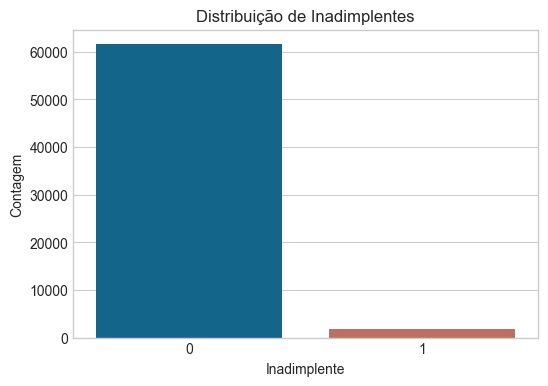

In [875]:
df_train_test['inadimplente'].value_counts(normalize=True)

# plotar gráfico para visualizar a distribuição de inadimplentes em df_train_test
# primeira coluna blue para 0, segunda coluna red para 1

plt.figure(figsize=(6,4))
sns.countplot(x='inadimplente', data=df_train_test, palette=[blue, red])
plt.title('Distribuição de Inadimplentes')
plt.xlabel('Inadimplente')
plt.ylabel('Contagem')
plt.show()

In [876]:
train_cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
test_cat_cols = X_test.select_dtypes(include=['object', 'category']).columns.tolist()
val_cat_cols = X_val.select_dtypes(include=['object', 'category']).columns.tolist()

print("Train categorical columns:", train_cat_cols)
print("Validation categorical columns:", val_cat_cols)
print("Test categorical columns:", test_cat_cols)

Train categorical columns: []
Validation categorical columns: []
Test categorical columns: []


# PSI

In [877]:
from src.calculate_psi import analyze_psi

In [878]:
analyze_psi(X_train, X_test)

Calculando PSI para 72 colunas...


,Coluna,PSI,Status
70,data_decisao_mes,7.739204,Instável
69,hist_valor_parcela_6m_sum,0.085665,Estável
68,hist_valor_parcela_6m_max,0.082019,Estável
64,hist_valor_bem_6m_sum,0.080954,Estável
59,hist_valor_credito_6m_sum,0.080954,Estável
...,...,...,...
47,hist_valor_bem_3m_min,0.000000,Estável
48,hist_valor_bem_3m_max,0.000000,Estável
49,hist_valor_bem_3m_sum,0.000000,Estável
50,hist_valor_parcela_3m_mean,0.000000,Estável


In [879]:
X_train.drop('data_decisao_mes', axis=1, inplace=True)
X_val.drop('data_decisao_mes', axis=1, inplace=True)
X_test.drop('data_decisao_mes', axis=1, inplace=True)

# Modelagem

In [880]:
default_params = {
    'class_weight': 'balanced',
    'seed': 42,
    'verbosity': -1  # silencia logs do LightGBM
}

model_lgbm = lgb.LGBMClassifier(**default_params)
model_lgbm.fit(X_train, y_train)

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,'balanced'
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Modelo 'LGBMClassifier' detectado como 'treinado'.
Clonando modelo (com os mesmos hiperparâmetros) para novo treinamento...


,Métrica,Valor
0,AUC (ROC),0.6013
1,PR-AUC,0.0141
2,KS Statistic,0.2015
3,KS Threshold,0.3768
4,Precision (no KS),0.0149
5,Recall (no KS),0.6392


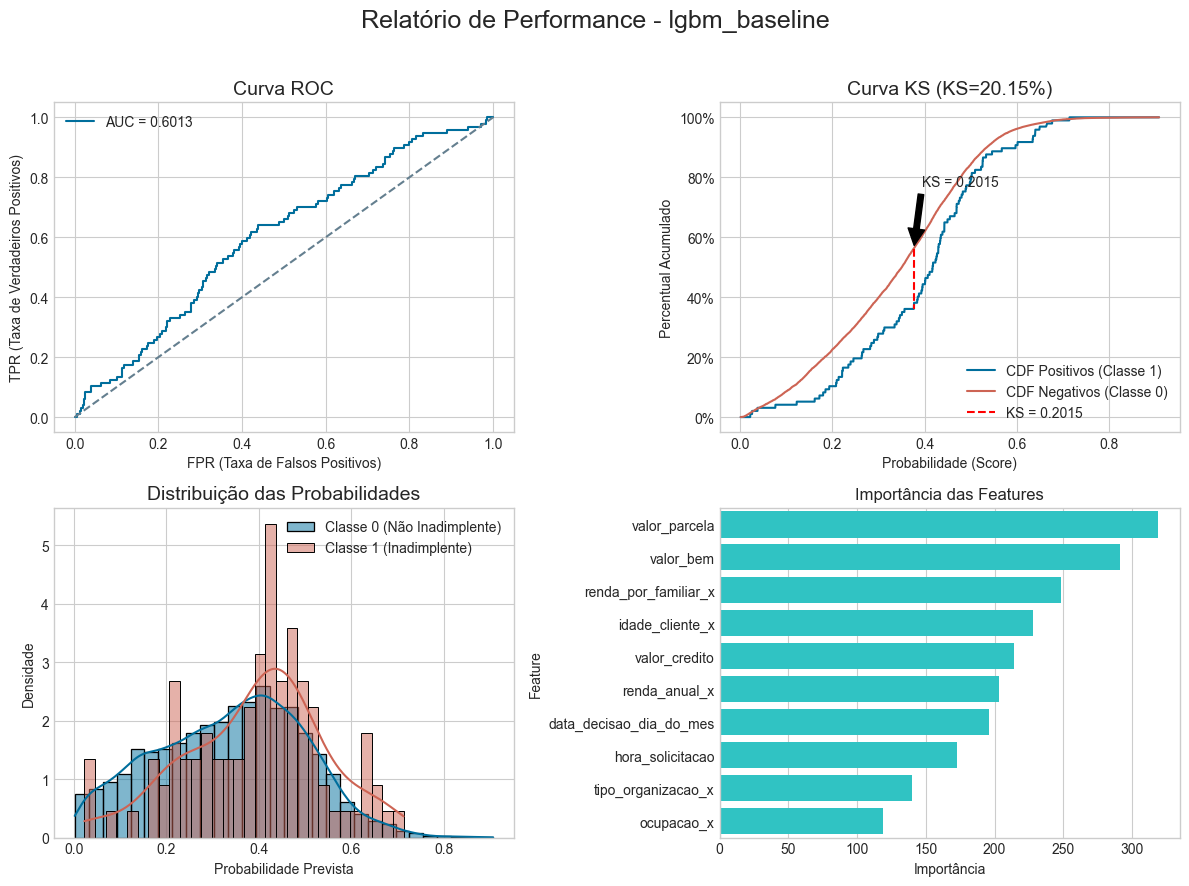

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lgbm_baseline.joblib


In [881]:
models_dir = os.path.join(project_root, 'models')

run_experiment(model_lgbm, X_train, y_train, 
               X_test, y_test, 
               experiment_name='lgbm_baseline', 
               dir_path=models_dir)

In [882]:
from src.prediction_report import get_feature_importance_df  

feature_importance_df = get_feature_importance_df(model_lgbm, X_train.columns)

In [883]:
feature_importance_df

,Feature,Importance
5,valor_parcela,319
4,valor_bem,291
20,renda_por_familiar_x,248
19,idade_cliente_x,228
3,valor_credito,214
...,...,...
24,tipo_renda_y,0
23,renda_anual_y,0
22,qtd_membros_familia_y,0
21,qtd_filhos_y,0


In [884]:
non_zero_features = feature_importance_df[feature_importance_df['Importance'] > 0]['Feature'].to_list()
print(f"Selected {len(non_zero_features)} features with importance > 0.")
print("Selected features:", non_zero_features[:10])  # mostra as primeiras 10 features selecionadas

Selected 52 features with importance > 0.
Selected features: ['valor_parcela', 'valor_bem', 'renda_por_familiar_x', 'idade_cliente_x', 'valor_credito', 'renda_anual_x', 'data_decisao_dia_do_mes', 'hora_solicitacao', 'tipo_organizacao_x', 'ocupacao_x']


In [885]:
selected_features = feature_importance_df.head(43)['Feature'].to_list()

In [886]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

# Salvando os datasets com features selecionadas
df_train_selected = df_train_abt[selected_features + ['inadimplente', 'safra']]
df_val_selected = df_val_abt[selected_features + ['inadimplente', 'safra']]
df_test_selected = df_test_abt[selected_features + ['inadimplente', 'safra']]

df_train_selected.to_parquet('../data/df_train_selected.parquet')
df_val_selected.to_parquet('../data/df_val_selected.parquet')
df_test_selected.to_parquet('../data/df_test_selected.parquet')

In [887]:
df_train_selected['safra'].value_counts()

safra
2023-03    2112
2023-02    1951
2023-01    1936
2022-12    1885
2022-10    1740
2022-11    1726
2022-08    1620
2022-09    1615
2022-07    1498
2022-05    1431
2022-06    1408
2022-03    1325
2022-04    1284
2022-02    1207
2022-01    1185
2021-12    1046
2021-11     974
2021-10     962
2021-09     953
2021-01     944
2021-08     942
2021-07     896
2021-03     894
2021-05     877
2020-10     872
2021-06     866
2020-11     845
2020-12     827
2021-04     826
2021-02     813
2020-09     781
2020-06     742
2020-05     742
2020-04     736
2020-03     713
2020-02     676
2020-07     674
2020-08     671
2020-01     634
2023-04     481
Name: count, dtype: int64

Modelo 'LGBMClassifier' detectado como 'treinado'.
Clonando modelo (com os mesmos hiperparâmetros) para novo treinamento...


,Métrica,Valor
0,AUC (ROC),0.6131
1,PR-AUC,0.0167
2,KS Statistic,0.2096
3,KS Threshold,0.3824
4,Precision (no KS),0.0151
5,Recall (no KS),0.6392


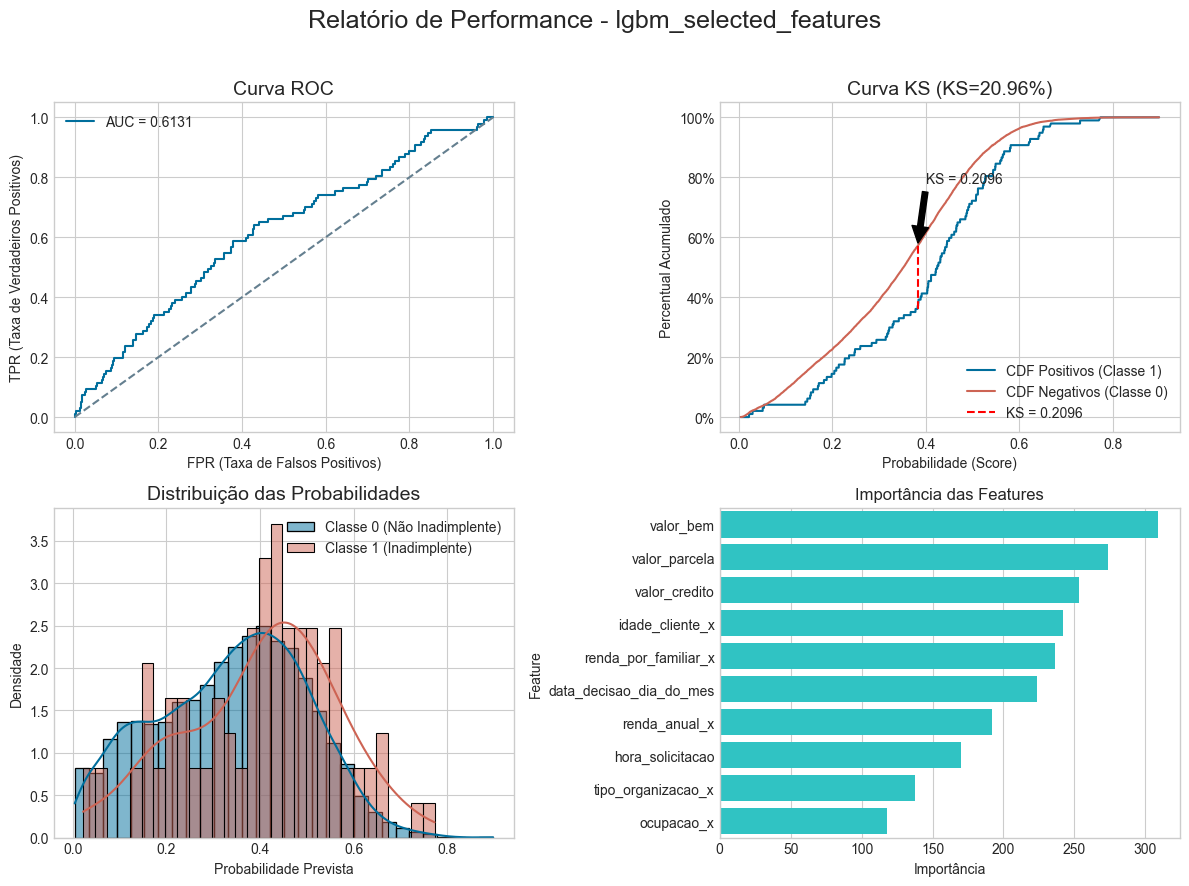

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lgbm_selected_features.joblib


In [888]:
run_experiment(model_lgbm, X_train_selected, y_train, 
               X_test_selected, y_test, 
               experiment_name='lgbm_selected_features', 
               dir_path=models_dir) 

In [889]:
import optuna

search_space = {
        "n_estimators": lambda trial: trial.suggest_int("n_estimators", 200, 2000),
        "learning_rate": lambda trial: trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": lambda trial: trial.suggest_int("num_leaves", 20, 500),
        "max_depth": lambda trial: trial.suggest_int("max_depth", 3, 12),
        "lambda_l1": lambda trial: trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": lambda trial: trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": lambda trial: trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": lambda trial: trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": lambda trial: trial.suggest_int("bagging_freq", 1, 7),
    }

def objective(trial, X_train, y_train, X_val, y_val):
    """
    Função genérica que o Optuna irá otimizar.
    Ela recebe o nome do modelo, busca seus parâmetros e retorna o score (AUC).
    """

    # 2. Cria o dicionário de parâmetros usando as sugestões do trial
    params = {name: func(trial) for name, func in search_space.items()}
    model = lgb.LGBMClassifier(objective='binary', verbosity=-1, random_state=42, class_weight='balanced', **params)

    # 4. Treina e avalia o modelo
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc

In [890]:
study = optuna.create_study(direction='maximize', study_name=f"lgbm_optimization")

# Otimiza a função objective, passando os argumentos extras através de um lambda
study.optimize(
    lambda trial: objective(trial, X_train_selected, y_train, X_val_selected, y_val),
    n_trials=20  # Defina o número de tentativas que desejar
)

[I 2025-11-25 14:24:46,169] A new study created in memory with name: lgbm_optimization
[W 2025-11-25 14:24:49,341] Trial 0 failed with parameters: {'n_estimators': 1691, 'learning_rate': 0.016084144797033798, 'num_leaves': 391, 'max_depth': 6, 'lambda_l1': 0.18193126367349366, 'lambda_l2': 0.0009763150853024096, 'feature_fraction': 0.9912068099262034, 'bagging_fraction': 0.9603915711341826, 'bagging_freq': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/jvlm/repositories/case-ds/.venv/lib/python3.13/site-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/ipykernel_52637/4179141474.py", line 5, in <lambda>
    lambda trial: objective(trial, X_train_selected, y_train, X_val_selected, y_val),
                  ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/py/_hms0lwn3h70z03wxhxl24jm0000gp/T/

KeyboardInterrupt: 

Modelo 'LGBMClassifier' detectado como 'não treinado'.
Usando a instância original para o treinamento...


,Métrica,Valor
0,AUC (ROC),0.6464
1,PR-AUC,0.0197
2,KS Statistic,0.2566
3,KS Threshold,0.4381
4,Precision (no KS),0.0160
5,Recall (no KS),0.7010


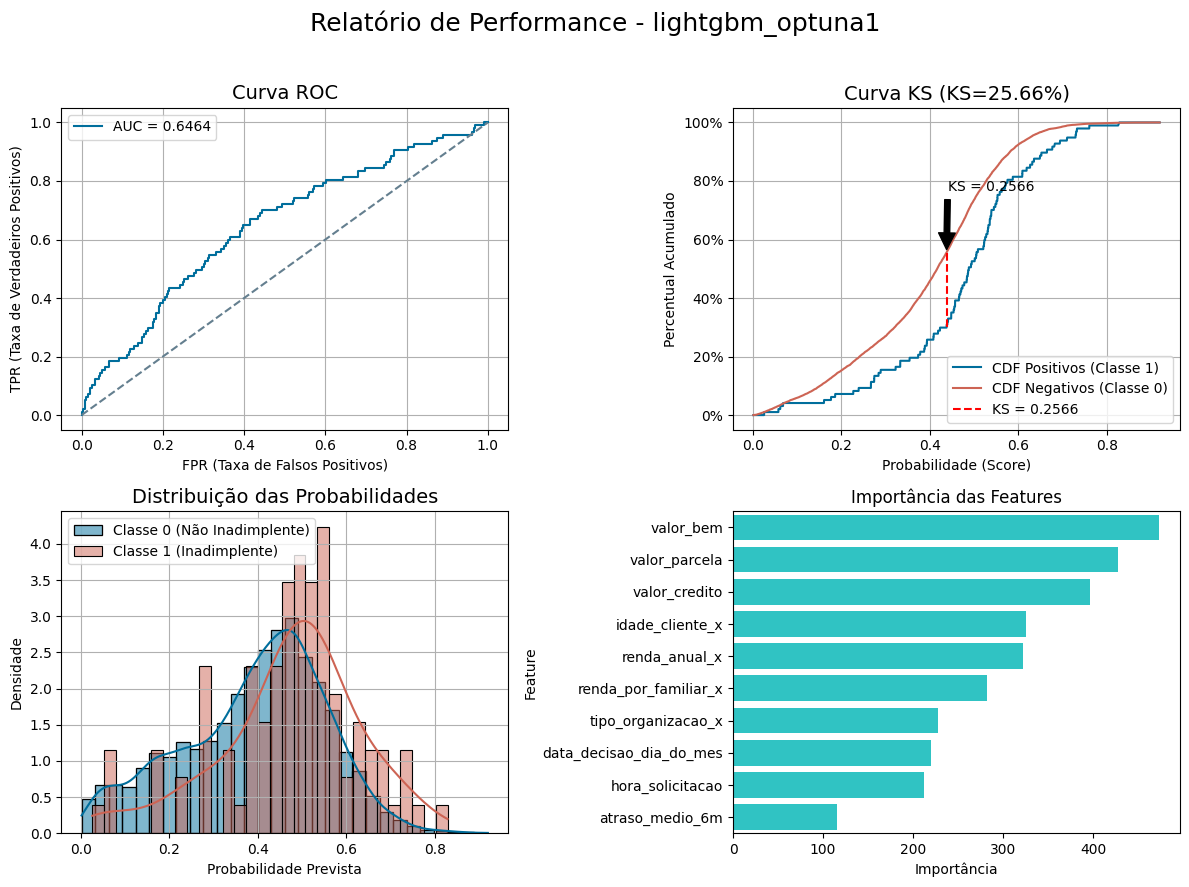

Modelo salvo em: /Users/jvlm/repositories/case-ds/models/lightgbm_optuna1.joblib


In [ ]:
best_params = study.best_trial.params
model = lgb.LGBMClassifier(**best_params, **default_params)

run_experiment(model, experiment_name="lightgbm_optuna1", dir_path=models_dir, X_train=X_train_selected, y_train=y_train, 
                X_test=X_test_selected, y_test=y_test)

# SHAP

In [ ]:
from joblib import load

model = load("../models/lightgbm_optuna1.joblib")['model']

/Users/jvlm/repositories/case-ds/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


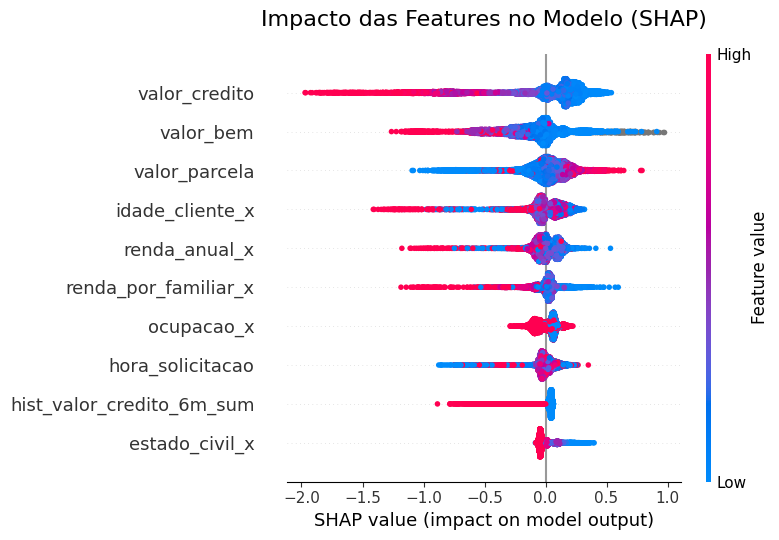

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load

# 1. Carregar o modelo
loaded_object = load("../models/lightgbm_optuna1.joblib")
model = loaded_object['model']

# Criar o Explainer
# Para LightGBM/XGBoost/CatBoost, use TreeExplainer (muito mais rápido que KernelExplainer)
explainer = shap.TreeExplainer(model)

# Calcular os shap_values
shap_values = explainer.shap_values(X_test_selected)

# TRATAMENTO PARA CLASSIFICAÇÃO BINÁRIA:
# O LightGBM geralmente retorna uma lista com dois arrays [shap_classe_0, shap_classe_1].
# Queremos explicar a classe positiva (1 - Default/Fraude/Evento).
if isinstance(shap_values, list):
    print("Detectada saída binária (lista). Usando classe 1.")
    shap_values = shap_values[1]

# 5. Gerar o Summary Plot (Beeswarm)
plt.figure(figsize=(10, 8)) # Ajuste o tamanho conforme necessário
shap.summary_plot(
    shap_values, 
    X_test_selected, 
    show=False, # Permite ajustes no matplotlib antes de mostrar
    max_display=10 # Quantas features mostrar no gráfico
)

# Ajustes finais e exibição
plt.title("Impacto das Features no Modelo (SHAP)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()